In [1]:
import numpy as np
import torch
print(torch.__version__)

np.random.seed(42)

0.4.1


Here goes our main class: a layer that can .forward() and .backward().

In [2]:
class Layer:
    def __init__(self):
        pass
    
    def forward(self, input):
        pass
    
    def backward(self, input, grad_output):
        pass

### The road ahead

We're going to build a neural network that classifies MNIST digits. To do so, we'll need a few building blocks:
- Dense layer - a fully-connected layer, $f(X)=X \cdot W + \vec{b}$
- ReLU layer (or any other nonlinearity you want)
- Loss function - crossentropy
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.


### Nonlinearity layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

In [4]:
class ReLU(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):
        output = torch.max(input, torch.tensor([0.], device='cpu'))
        return output

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= X \cdot W + \vec b $$

Where 
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called.

In [5]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers. We use normal initialization, 
        # but surely there is something better. Try this once you got it working: http://bit.ly/2vTlmaJ
        self.weights = torch.randn(input_units, output_units, device='cpu', requires_grad=True)*0.01
        self.biases  = torch.ones(output_units, device='cpu', requires_grad=True)
        
    def forward(self,input):
        return torch.matmul(input, self.weights) + self.biases
    
    def backward(self, w_grad, b_grad):
        self.weights = self.weights - self.learning_rate * w_grad
        self.biases  = self.biases - self.learning_rate * b_grad

### Testing the dense layer

Here we have a few tests to make sure your dense layer works properly. You can just run them, get 3 "well done"s and forget they ever existed.

... or not get 3 "well done"s and go fix stuff. If that is the case, here are some tips for you:
* Make sure you compute gradients for W and b as __sum of gradients over batch__, not mean over gradients. Grad_output is already divided by batch size.
* If you're debugging, try saving gradients in class fields, like "self.grad_w = grad_w" or print first 3-5 weights. This helps debugging.
* If nothing else helps, try ignoring tests and proceed to network training. If it trains alright, you may be off by something that does not affect network training.

In [6]:
l = Dense(3, 4)
x = torch.linspace(-1,1,2*3, device='cpu', requires_grad=True).view([2,3])
l.forward(x)
print("Well done!")

Well done!


### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If you write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If you take a closer look, ya'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

Here you are! We've defined the both loss functions for you so that you could focus on neural network part.

### Full network

Now let's combine what we've just built into a working neural network. As we announced, we're gonna use this monster to classify handwritten digits, so let's get them loaded.

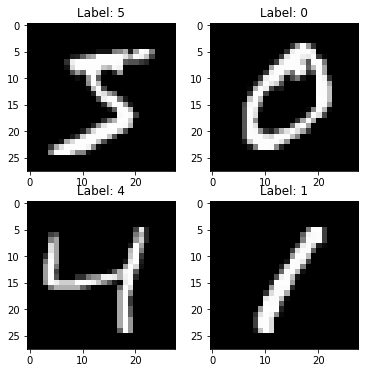

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

from mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [8]:
X_train = torch.from_numpy(X_train).float().to('cpu')
X_train.requires_grad_(True)

X_val = torch.from_numpy(X_val).float().to('cpu')
X_val.requires_grad_(True)

X_test = torch.from_numpy(X_test).float().to('cpu')
X_test.requires_grad_(True)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)

In [9]:
network = []
network.append(Dense(X_train.shape[1], 100))
network.append(ReLU())
network.append(Dense(100, 200))
network.append(ReLU())
network.append(Dense(200, 10))

# network = []
# network.append(Dense(X_train.shape[1], 100))
# network.append(ReLU())
# network.append(Dense(100, 10))

In [58]:
# act = forward(network, X_train[:2])

In [59]:
# K        = 1
# beta     = .1
# n_layers = len(network) // 2 + 1
# layer    = n_layers

# pre_activations     = act[::2] # h
# pre_activations_tmp = pre_activations.copy() # h_hat

# post_activations     = [X_train[:2]] + act[1::2] # z
# layer_post_target    = post_activations.copy() # y_z
# post_activations_tmp = post_activations.copy() # z_hat

# layer_post_target[-1] = torch.from_numpy(y_train[:2]).long().to('cuda')

# print('Before updates ...')
# print('Pre activation ', pre_activations)
# print('Post activation ', post_activations)

# for l in range(len(network) - 1, 0, -2):
#     W                   = torch.from_numpy(network[l].weights.cpu().detach().numpy()).to('cuda')
#     W.requires_grad_(True)
#     b                   = network[l].biases

#     z_l_1                = torch.from_numpy(post_activations[layer-1].cpu().detach().numpy()).to('cuda') # z_(l-1)
#     z_l_1.requires_grad_(True)  
#     z_l                  = torch.matmul(z_l_1, W) + b # z_l
    
#     print('Layer: ', layer)
#     print(layer_post_target[layer - 1])
#     print()
#     loss = torch.functional.F.nll_loss(z_l, layer_post_target[layer-1])
#     loss.backward()

#     W_grad = W.grad
#     b_grad = b.grad
    
#     for k in range(K):
#         h_l_1  = torch.from_numpy(pre_activations[layer-2].cpu().detach().numpy()).to('cuda')
#         h_l_1.requires_grad_(True)

#         z_l_1  = network[l-1].forward(h_l_1)
#         z_l    = torch.matmul(z_l_1, W) + b
        
#         loss   = torch.functional.F.nll_loss(z_l, layer_post_target[layer-1])
#         loss.backward()

#         h_l_1_grad            = h_l_1.grad
        
#         # updates
#         pre_activations[layer-2]  = h_l_1 - beta * h_l_1_grad
#         post_activations[layer-1] = network[l-1].forward(pre_activations[layer-1])
#         pre_activations[layer-1]  = torch.matmul(z_l_1, W) + b
        
# #         if layer != n_layers-1:
# #             post_activations[layer] = network[l].forward(pre_activations[layer-1])

#     layer_post_target[layer-2] = torch.argmax(post_activations[layer-2], dim=-1)
    
#     layer -= 1

# print('\n\nAfter updates ...')
# print('Pre activation ', pre_activations)
# print('Post activation ', post_activations)

In [15]:
def forward(network, X):
    activations = []
    input       = X
    
    for layer in network:
        input = layer.forward(input)
        activations.append(input)
        
    assert len(activations) == len(network)
    return activations

def predict(network, X):
    logits = forward(network, X)[-1]
    return logits.cpu().detach().numpy().argmax(axis=-1)

def normalize(vec, c):
    norm = torch.norm(vec)
    
    if norm >= c:
        return (c * vec) / norm
    else:
        return vec

### LRA-diff

In [68]:
def train(network,X,y):
    
    # parameters
    K        = 1
    beta     = .001
    n_layers = len(network) // 2 + 1
    layer    = n_layers
    c        = 1
    
    # forward pass
    act = forward(network, X)
    
    pre_activations      = act[::2] # h
    pre_activations_tmp  = pre_activations.copy() # h_hat

    post_activations     = [X] + act[1::2] # z
    layer_post_target    = post_activations.copy() # y_z
    post_activations_tmp = post_activations.copy() # z_hat

    layer_post_target[-1] = torch.from_numpy(y).long().to('cpu')
    W_grads               = []
    b_grads               = []
    
    for l in range(len(network) - 1, 0, -2):
        W                   = torch.from_numpy(network[l].weights.cpu().detach().numpy()).to('cpu')
        W.requires_grad_(True)
        
        b                   = torch.from_numpy(network[l].biases.cpu().detach().numpy()).to('cpu')
        b.requires_grad_(True)
        
        z_l_1                = torch.from_numpy(post_activations[layer-1].cpu().detach().numpy()).to('cpu') # z_(l-1)
        z_l_1.requires_grad_(True)  
        z_l                  = torch.matmul(z_l_1, W) + b # z_l

        loss = torch.functional.F.nll_loss(z_l, layer_post_target[layer-1])
        loss.backward()
        
        w_grad = normalize(W.grad, c)
        b_grad = normalize(b.grad, c)

        W_grads.append(w_grad)
        b_grads.append(b_grad)
        
        W.grad.zero_()
        b.grad.zero_()
        
        for k in range(K):
            h_l_1  = torch.from_numpy(pre_activations[layer-2].cpu().detach().numpy()).to('cpu')
            h_l_1.requires_grad_(True)

            z_l_1  = network[l-1].forward(h_l_1)
            z_l    = torch.matmul(z_l_1, W) + b

            loss   = torch.functional.F.nll_loss(z_l, layer_post_target[layer-1])
            loss.backward()

            h_l_1_grad            = h_l_1.grad

            # updates
            pre_activations[layer-2]  = h_l_1 - beta * h_l_1_grad
            post_activations[layer-1] = network[l-1].forward(pre_activations[layer-1])
            pre_activations[layer-1]  = torch.matmul(z_l_1, W) + b
            
            h_l_1.grad.zero_()

#             if layer != n_layers-1:
#                 post_activations[layer-1] = network[l].forward(pre_activations[layer-1])

        layer_post_target[layer-2] = torch.argmax(post_activations[layer-2], dim=-1)
        layer -= 1
    
        
    return W_grads[::-1], b_grads[::-1]

Instead of tests, we provide you with a training loop that prints training and validation accuracies on every epoch.

If your implementation of forward and backward are correct, your accuracy should grow from 90~93% to >97% with the default network.

### Training loop

As usual, we split data into minibatches, feed each such minibatch into the network and update weights.

In [69]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [70]:
from IPython.display import clear_output
train_log = []
val_log = []

In [71]:
network = []
network.append(Dense(X_train.shape[1], 100))
network.append(ReLU())
network.append(Dense(100, 200))
network.append(ReLU())
network.append(Dense(200, 10))

In [72]:
for epoch in range(2):
    print('*' * 100)
    print(network[-1].weights[:10])
        
    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        
        W_grads, b_grads = train(network, x_batch, y_batch)
        layer    = 0
        
        for l in range(2, len(network), 2):
            network[l].backward(W_grads[layer], b_grads[layer])
            layer += 1
    
    print()
    print(network[-1].weights[:10])
        
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
#     clear_output()
#     print("Epoch",epoch)
#     print("Train accuracy:",train_log[-1])
#     print("Val accuracy:",val_log[-1])
#     plt.plot(train_log,label='train accuracy')
#     plt.plot(val_log,label='val accuracy')
#     plt.legend(loc='best')
#     plt.grid()
#     plt.show()
    

  2%|▏         | 28/1562 [00:00<00:05, 277.60it/s]

****************************************************************************************************
tensor([[ 0.0063, -0.0128, -0.0003, -0.0051, -0.0084,  0.0088, -0.0187,  0.0196,
         -0.0060,  0.0036],
        [-0.0140,  0.0014, -0.0141,  0.0101, -0.0233,  0.0106,  0.0017,  0.0266,
         -0.0046, -0.0051],
        [-0.0012,  0.0042, -0.0119, -0.0130,  0.0122,  0.0110,  0.0087,  0.0130,
         -0.0234, -0.0005],
        [-0.0022, -0.0198,  0.0328, -0.0024, -0.0061, -0.0070, -0.0052, -0.0023,
          0.0084, -0.0031],
        [-0.0012, -0.0069, -0.0010, -0.0191, -0.0121,  0.0033,  0.0098, -0.0018,
         -0.0072,  0.0141],
        [-0.0049,  0.0289, -0.0095, -0.0084, -0.0067, -0.0014, -0.0092,  0.0048,
          0.0093, -0.0123],
        [-0.0062,  0.0240,  0.0020,  0.0009, -0.0105,  0.0044, -0.0072,  0.0006,
         -0.0133, -0.0068],
        [ 0.0093, -0.0122,  0.0029,  0.0113, -0.0015, -0.0059, -0.0147, -0.0041,
          0.0223,  0.0071],
        [ 0.0025,  0.0122, 

100%|██████████| 1562/1562 [00:04<00:00, 317.35it/s]



tensor([[ 0.1902,  0.1869,  0.1882,  0.1725,  0.1673,  0.1686,  0.1563,  0.2120,
          0.1686,  0.1896],
        [ 0.3449,  0.4023,  0.3511,  0.3692,  0.3256,  0.3315,  0.3560,  0.4006,
          0.3445,  0.3564],
        [ 0.2617,  0.2976,  0.2580,  0.2489,  0.2679,  0.2451,  0.2662,  0.2895,
          0.2313,  0.2664],
        [ 0.1669,  0.1625,  0.2044,  0.1593,  0.1551,  0.1393,  0.1555,  0.1742,
          0.1683,  0.1679],
        [ 0.3444,  0.3794,  0.3499,  0.3266,  0.3245,  0.3119,  0.3509,  0.3591,
          0.3285,  0.3629],
        [ 6.7961,  7.8097,  6.8799,  7.0443,  6.6850,  6.2421,  6.8467,  7.1112,
          6.7143,  6.8521],
        [ 1.8980,  2.1936,  1.9273,  1.9645,  1.8607,  1.7448,  1.9075,  1.9869,
          1.8591,  1.9111],
        [ 0.1788,  0.1750,  0.1773,  0.1753,  0.1622,  0.1422,  0.1484,  0.1747,
          0.1845,  0.1796],
        [ 1.9558,  2.2393,  1.9873,  2.0279,  1.9198,  1.7750,  1.9700,  2.0355,
          1.9136,  1.9853],
        [16.9035, 

  2%|▏         | 39/1562 [00:00<00:03, 382.33it/s]

****************************************************************************************************
tensor([[ 0.1902,  0.1869,  0.1882,  0.1725,  0.1673,  0.1686,  0.1563,  0.2120,
          0.1686,  0.1896],
        [ 0.3449,  0.4023,  0.3511,  0.3692,  0.3256,  0.3315,  0.3560,  0.4006,
          0.3445,  0.3564],
        [ 0.2617,  0.2976,  0.2580,  0.2489,  0.2679,  0.2451,  0.2662,  0.2895,
          0.2313,  0.2664],
        [ 0.1669,  0.1625,  0.2044,  0.1593,  0.1551,  0.1393,  0.1555,  0.1742,
          0.1683,  0.1679],
        [ 0.3444,  0.3794,  0.3499,  0.3266,  0.3245,  0.3119,  0.3509,  0.3591,
          0.3285,  0.3629],
        [ 6.7961,  7.8097,  6.8799,  7.0443,  6.6850,  6.2421,  6.8467,  7.1112,
          6.7143,  6.8521],
        [ 1.8980,  2.1936,  1.9273,  1.9645,  1.8607,  1.7448,  1.9075,  1.9869,
          1.8591,  1.9111],
        [ 0.1788,  0.1750,  0.1773,  0.1753,  0.1622,  0.1422,  0.1484,  0.1747,
          0.1845,  0.1796],
        [ 1.9558,  2.2393, 

100%|██████████| 1562/1562 [00:04<00:00, 325.84it/s]



tensor([[ 0.2181,  0.2190,  0.2162,  0.2013,  0.1946,  0.1942,  0.1840,  0.2412,
          0.1959,  0.2177],
        [ 0.5275,  0.6111,  0.5361,  0.5584,  0.5054,  0.4990,  0.5399,  0.5911,
          0.5243,  0.5406],
        [ 0.3522,  0.4018,  0.3498,  0.3430,  0.3571,  0.3284,  0.3573,  0.3843,
          0.3205,  0.3579],
        [ 0.1895,  0.1882,  0.2268,  0.1824,  0.1771,  0.1599,  0.1778,  0.1977,
          0.1903,  0.1906],
        [ 0.5495,  0.6145,  0.5578,  0.5393,  0.5267,  0.5003,  0.5578,  0.5737,
          0.5308,  0.5701],
        [13.4497, 15.4285, 13.6306, 13.9570, 13.2414, 12.3536, 13.5610, 14.0666,
         13.2814, 13.5713],
        [ 3.7275,  4.2907,  3.7836,  3.8651,  3.6645,  3.4260,  3.7538,  3.9003,
          3.6646,  3.7598],
        [ 0.2034,  0.2037,  0.2021,  0.2008,  0.1866,  0.1649,  0.1731,  0.2006,
          0.2087,  0.2046],
        [ 3.7379,  4.2806,  3.7946,  3.8787,  3.6772,  3.4127,  3.7691,  3.8993,
          3.6723,  3.7864],
        [33.9085, 

In [32]:
val_log

[0.1064]

In [73]:
val_log

[0.1064, 0.1064]

__What should you see:__ `train accuracy` should increase to near-100%. Val accuracy will also increase, allbeit to a smaller value.

__What else to try:__ You can try implementing different nonlinearities, dropout or composing neural network of more layers. See how this affects training speed, overfitting & final quality.

Good hunting!

In [ ]:
# and yes, it's perfectly legal to reuse your code from this seminar in homework01.